<a href="https://colab.research.google.com/github/kridtapon/Fractal-VIX-Reversion/blob/main/Fractal_VIX_Reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Download data
symbol = 'CAH'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Williams VIX Fix ---
def vix_fix(df, period=22):
    # Simplified VIX Fix calculation
    highest_close = df['Close'].rolling(window=period).max()
    vix = ((highest_close - df['Low']) / highest_close) * 100
    vix_avg = vix.rolling(window=period).mean()
    return vix, vix_avg

df['VIX_Fix'], df['VIX_Fix_Avg'] = vix_fix(df)

# --- Fractal Chaos Bands ---
def fractal_bands(df, period=13):
    upper_band = df['High'].rolling(window=period).max()
    lower_band = df['Low'].rolling(window=period).min()
    return upper_band, lower_band

df['Fractal_Upper'], df['Fractal_Lower'] = fractal_bands(df)

# --- Entry & Exit Conditions ---
vix_spike = df['VIX_Fix'] > 1.5 * df['VIX_Fix_Avg']
price_near_lower_band = df['Close'] <= df['Fractal_Lower'] * 1.01
price_near_upper_band = df['Close'] >= df['Fractal_Upper'] * 0.99

# Filter data (2020–2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df['Entry'] = vix_spike | price_near_lower_band
df['Exit'] = (~vix_spike) & price_near_upper_band

# Shift signals
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Show performance
print(portfolio.stats())

# Plot results
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  225710.776391
Total Return [%]                              125.710776
Benchmark Return [%]                          167.585319
Max Gross Exposure [%]                             100.0
Total Fees Paid                             16509.013508
Max Drawdown [%]                               25.642191
Max Drawdown Duration                  195 days 00:00:00
Total Trades                                          47
Total Closed Trades                                   46
Total Open Trades                                      1
Open Trade PnL                              -6140.341437
Win Rate [%]                                   73.913043
Best Trade [%]                                 22.892445
Worst Trade [%]                

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
<ipython-input-15-7b3a30b63fbd>:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-7b3a30b63fbd>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-7b3a30b63fbd>:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Best Parameters:
vix_fix_period           17.000000
fractal_bands_period     20.000000
total_return            172.206928
Name: 327, dtype: float64


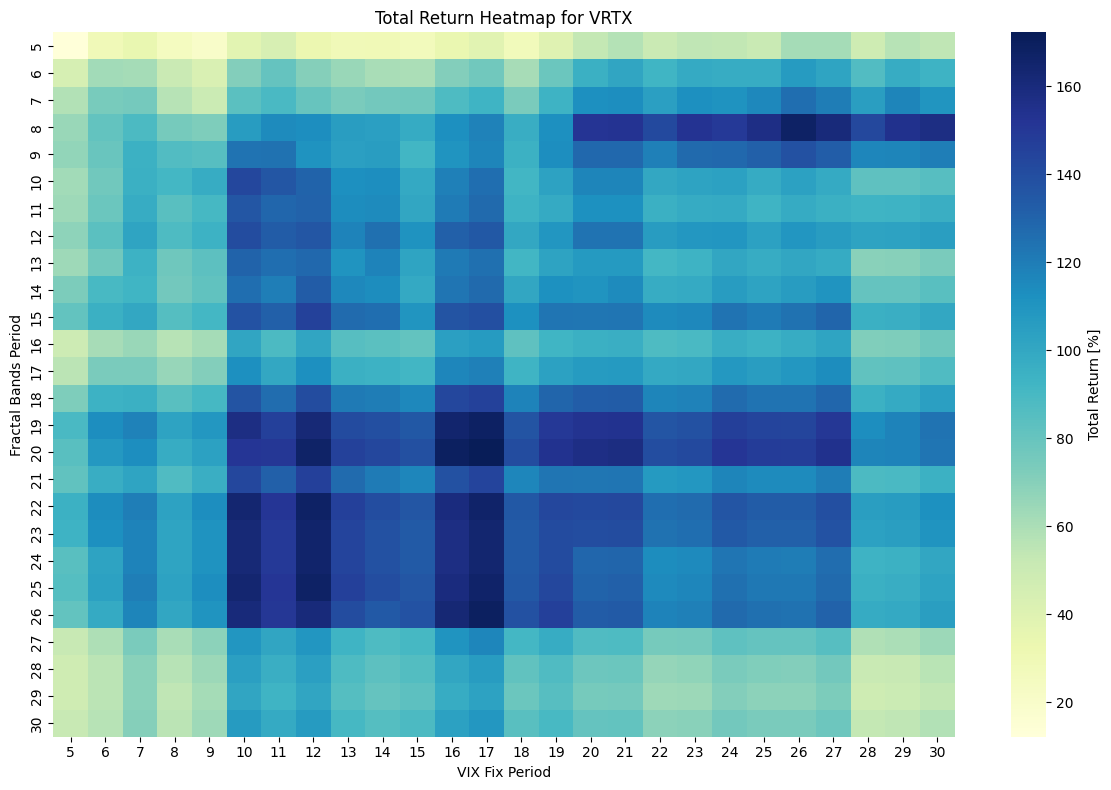

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Download data
symbol = 'VRTX'
start_date = '2019-01-01'
end_date = '2025-01-01'
df_raw = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Define parameter ranges
vix_fix_period_range = range(5, 31)
fractal_bands_period_range = range(5, 31)

# Optimization results container
results = []

# --- Optimization Loop ---
for vix_fix_period, fractal_bands_period in itertools.product(vix_fix_period_range, fractal_bands_period_range):
    df = df_raw.copy()

    # --- Williams VIX Fix ---
    highest_close = df['Close'].rolling(window=vix_fix_period).max()
    vix = ((highest_close - df['Low']) / highest_close) * 100
    vix_avg = vix.rolling(window=vix_fix_period).mean()
    df['VIX_Fix'] = vix
    df['VIX_Fix_Avg'] = vix_avg

    # --- Fractal Chaos Bands ---
    upper_band = df['High'].rolling(window=fractal_bands_period).max()
    lower_band = df['Low'].rolling(window=fractal_bands_period).min()
    df['Fractal_Upper'] = upper_band
    df['Fractal_Lower'] = lower_band

    # --- Entry & Exit Conditions ---
    vix_spike = df['VIX_Fix'] > 1.5 * df['VIX_Fix_Avg']
    price_near_lower_band = df['Close'] <= df['Fractal_Lower'] * 1.01
    price_near_upper_band = df['Close'] >= df['Fractal_Upper'] * 0.99

    # Filter data (2020–2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    df_test['Entry'] = (vix_spike | price_near_lower_band)
    df_test['Exit'] = (~vix_spike) & price_near_upper_band

    # Shift signals
    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    if entries.any() and exits.any():
        # Portfolio
        pf = vbt.Portfolio.from_signals(
            close=df_test['Open'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )

        stats = pf.stats()
        total_return = stats['Total Return [%]']
        results.append({
            'vix_fix_period': vix_fix_period,
            'fractal_bands_period': fractal_bands_period,
            'total_return': total_return
        })

# --- Find Best Result ---
results_df = pd.DataFrame(results)
best = results_df.sort_values(by='total_return', ascending=False).iloc[0]
print("Best Parameters:")
print(best)

# --- Plot Heatmap ---
# Pivot the DataFrame for heatmap
heatmap_data = results_df.pivot(index='fractal_bands_period', columns='vix_fix_period', values='total_return')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap='YlGnBu', cbar_kws={'label': 'Total Return [%]'})
plt.title(f'Total Return Heatmap for {symbol}')
plt.xlabel('VIX Fix Period')
plt.ylabel('Fractal Bands Period')
plt.tight_layout()
plt.show()


In [16]:
df['VIX_Fix'], df['VIX_Fix_Avg'] = vix_fix(df, period=17)
df['Fractal_Upper'], df['Fractal_Lower'] = fractal_bands(df, period=20)

# --- Entry & Exit Conditions ---
vix_spike = df['VIX_Fix'] > 1.5 * df['VIX_Fix_Avg']
price_near_lower_band = df['Close'] <= df['Fractal_Lower'] * 1.01
price_near_upper_band = df['Close'] >= df['Fractal_Upper'] * 0.99

# Filter data (2020–2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df['Entry'] = vix_spike | price_near_lower_band
df['Exit'] = (~vix_spike) & price_near_upper_band

# Shift signals
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Show performance
print(portfolio.stats())

# Plot results
portfolio.plot().show()

<ipython-input-16-ab8e4bea9323>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-ab8e4bea9323>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  272206.927932
Total Return [%]                              172.206928
Benchmark Return [%]                            81.45205
Max Gross Exposure [%]                             100.0
Total Fees Paid                             16935.440082
Max Drawdown [%]                               22.926776
Max Drawdown Duration                  287 days 00:00:00
Total Trades                                          46
Total Closed Trades                                   45
Total Open Trades                                      1
Open Trade PnL                              -45607.24267
Win Rate [%]                                   77.777778
Best Trade [%]                                 14.545399
Worst Trade [%]                